In [224]:
import os
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(str(parent_dir))

In [225]:


class Retinex:
    def __init__(self, sigmas=np.arange(5, 500, 10), eps=1e-6):
        """
        Initialize the Retinex processor.

        Args:
            sigmas (list): List of Gaussian blur sigmas for MSR.
            eps (float): Small value to avoid division by zero or log(0).
        """
        self.sigmas = sigmas
        self.eps = eps

    def _gaussian_blur(self, img, sigma):
        return cv2.GaussianBlur(img, (0, 0), sigma)

    def apply(self, image):
        """
        Apply Multi-Scale Retinex to an RGB image.

        Args:
            image (np.ndarray): Input RGB image in uint8.

        Returns:
            reflectance (np.ndarray): Reflectance map in linear space.
            illumination (np.ndarray): Illumination estimate in linear space.
        """
        image = image.astype(np.float32) + self.eps
        log_img = np.log(image)

        retinex = np.zeros_like(image)
        illum = np.zeros_like(image)

        for sigma in self.sigmas:
            blur = self._gaussian_blur(image, sigma)
            log_blur = np.log(blur + self.eps)
            retinex += log_img - log_blur
            illum += log_blur

        illum = log_img - retinex
        retinex /= len(self.sigmas)
        illum /= len(self.sigmas)

        # Convert back to linear domain
        reflectance = np.exp(retinex)
        illumination = np.exp(illum)

        return reflectance, illumination

    def normalize(self, img):
        """
        Normalize an image to 0–255 uint8 for visualization.

        Args:
            img (np.ndarray): Image to normalize.

        Returns:
            np.ndarray: Normalized uint8 image.
        """
        img = img - img.min()
        img = img / (img.max() + self.eps)
        print(f"min={img.min()}, max={img.max()}")
        return np.uint8(np.clip(img * 255, 0, 255))

    def rgb_to_luminance(self, image_rgb):
        """
        Convert RGB image to a luminance-based grayscale image.

        Args:
            image_rgb (np.ndarray): RGB image, shape (H, W, 3), range [0, 1] or [0, 255].

        Returns:
            np.ndarray: Grayscale image, shape (H, W)
        """
        # return np.mean(image_rgb, axis=2, keepdims=True) 
        return 0.2126 * image_rgb[..., 0] + 0.7152 * image_rgb[..., 1] + 0.0722 * image_rgb[..., 2]

In [ ]:
# Load and convert to RGB
img_bgr = cv2.imread("lee_samuel_001.tif", cv2.IMREAD_UNCHANGED)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb = (img_rgb / 65535) * 255
print(f"img max: {img_rgb.shape}")

# Apply Retinex
retinex = Retinex()
reflectance, illumination = retinex.apply(img_rgb)

img max: (1023, 768, 3)


In [227]:
def keep_largest_connected_component(mask: np.ndarray) -> np.ndarray:
    """
    Keeps only the largest filled region in a binary mask.

    Args:
        mask (np.ndarray): Binary mask of shape (H, W), dtype bool or uint8.

    Returns:
        np.ndarray: Cleaned mask with only the largest region.
    """
    # Ensure mask is uint8
    mask_uint8 = mask.astype(np.uint8)

    # Get connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    if num_labels <= 1:
        return np.zeros_like(mask_uint8)  # No foreground

    # Get index of largest component (excluding background at index 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create output mask
    largest_mask = (labels == largest_label).astype(np.uint8)

    return largest_mask

min=0.0, max=0.9999999403953552
min=0.0, max=0.9999998807907104
89.88185
0.09953417
254
0


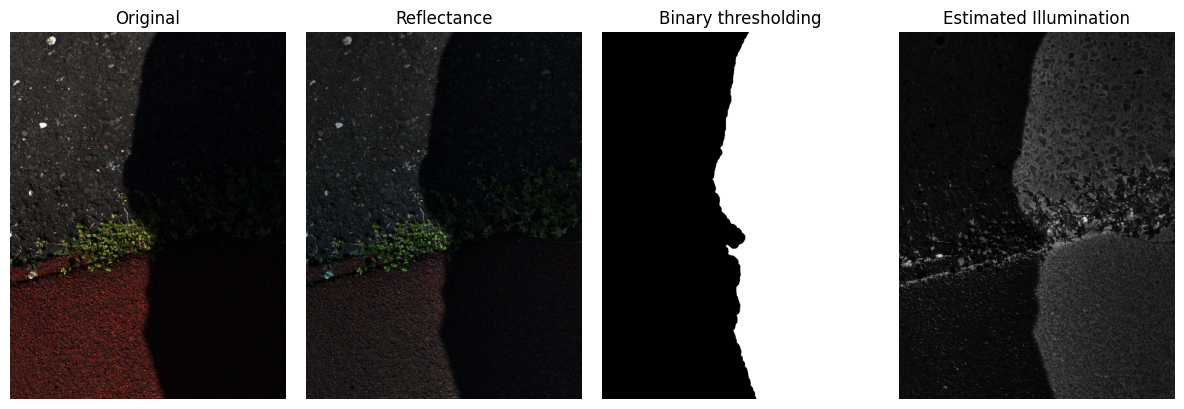

Mask shape: (1023, 768)


True

In [229]:
# Normalize for display
illumination_gray  = retinex.rgb_to_luminance(illumination)
reflectance_disp = retinex.normalize(reflectance)
illumination_disp = retinex.normalize(illumination_gray)
print(illumination.max())
print(illumination.min())
print(illumination_disp.max())
print(illumination_disp.min())
# illumination_disp = cv2.equalizeHist(illumination_disp)


threshold_value = 15  # You can adjust this value
max_value = 255
_, cleaned_mask = cv2.threshold(illumination_disp, threshold_value, max_value, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned_mask = cv2.morphologyEx(cleaned_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
cleaned_mask = keep_largest_connected_component(cleaned_mask)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (27, 27))
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

# Show results
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb.astype(np.uint8))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(reflectance_disp)
plt.title("Reflectance")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cleaned_mask, cmap="gray")
plt.title("Binary thresholding")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(illumination_disp, cmap='gray')
plt.title("Estimated Illumination")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Mask shape: {cleaned_mask.shape}")
cv2.imwrite("lee_samuel_001_mask.png", cleaned_mask)